In [9]:
pip install pandas numpy scikit-learn matplotlib seaborn streamlit

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

# Visualisation settings
sns.set(style='whitegrid')

# Task 1 Data Handling

In [3]:
# Load folder
data_folder = 'Assessment Data-20250428/'

# Load needed files
dongsi = pd.read_csv(data_folder + 'PRSA_Data_Dongsi_20130301-20170228.csv')
changping = pd.read_csv(data_folder + 'PRSA_Data_Changping_20130301-20170228.csv')
huairou = pd.read_csv(data_folder + 'PRSA_Data_Huairou_20130301-20170228.csv')
aotizhongxin = pd.read_csv(data_folder + 'PRSA_Data_Aotizhongxin_20130301-20170228.csv')

# Merge data to dataframe
air_quality_data = pd.concat([dongsi, changping, huairou, aotizhongxin], ignore_index=True)

# Preview merged dataset to ensure data is loaded correctly
print("Preview of merged dataset:")
air_quality_data.head()

# Export merged dataset
air_quality_data.to_csv("merged_air_data.csv", index=False)

Preview of merged dataset:


The provided dataset contained hourly air quality and weather-based data from 12 monitoring stations in Beijing. For this analysis, four stations were selected to represent a diverse range of environments:

- Dongsi - Urban
- Changping - Suburban
- Huairou - Rural
- Aotizhongin - Industrial/Hotspot

Each station's data was loaded from its respective file and merged into a dataframe named 'air_quality_data', a preview of the merged dataset is output to ensure that the structure and columns are loaded correctly.

# Task 2 Fundamental Data Understanding

In [5]:
# Import merged dataset
air_quality_data = pd.read_csv("merged_air_data.csv")

# Number of rows and columns using formatted string
print(f"Dataset contains {air_quality_data.shape[0]:,} rows and {air_quality_data.shape[1]} columns.\n")

# Data types, number of missing values and filled values
data_information = pd.DataFrame({
    "Data Type": air_quality_data.dtypes,
    "Missing Values": air_quality_data.isnull().sum(),
    "Filled Values": air_quality_data.notnull().sum()
})

print("Data information:")
display(data_information.T)

# Pollution data
pollution = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
print("Pollution data:")
display(air_quality_data[pollution].describe().T.round(2))

# Weather data
weather = ['TEMP', 'DEWP', 'PRES', 'RAIN', 'WSPM']
print("Weather data:")
display(air_quality_data[weather].describe().T.round(2))

Dataset contains 140,256 rows and 18 columns.

Data information:


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Data Type,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Missing Values,0,0,0,0,0,3402,2630,3206,4930,7916,4138,144,143,146,146,601,120,0
Filled Values,140256,140256,140256,140256,140256,136854,137626,137050,135326,132340,136118,140112,140113,140110,140110,139655,140136,140256


Pollution data:


,count,mean,std,min,25%,50%,75%,max
PM2.5,136854.0,77.43,78.67,2.00,19.0,53.0,108.0,898.0
PM10,137626.0,101.64,90.71,2.00,34.0,78.0,142.0,999.0
SO2,137050.0,15.75,21.61,0.29,2.0,7.0,19.0,341.0
NO2,135326.0,47.45,33.61,1.03,21.0,40.0,66.0,290.0
CO,132340.0,1189.96,1115.46,100.00,500.0,800.0,1500.0,10000.0
O3,136118.0,57.84,56.25,0.21,13.0,46.0,81.0,1071.0


Weather data:


,count,mean,std,min,25%,50%,75%,max
TEMP,140112.0,13.35,11.51,-19.9,3.0,14.3,23.1,41.4
DEWP,140110.0,2.33,13.86,-43.4,-9.2,2.9,15.0,29.1
PRES,140113.0,1009.94,10.48,982.4,1001.5,1009.5,1018.1,1042.0
RAIN,140110.0,0.06,0.83,0.0,0.0,0.0,0.0,72.5
WSPM,140136.0,1.77,1.25,0.0,0.9,1.4,2.2,12.9


The merged dataset was explored to gain an understanding of its structure and contents. This included the number of rows and columns, data types and the number of filled and missing values.

A table was created to display each columns data type and number of filled and missing values. The table showed that several of the statistics such as 'CO', 'NO2' and 'O3' had a signinficant number of missing values that require preprocessing.

Evaluative metrics were created and split into two groups:
- Pollution: PM2.5, PM10, SO2, NO2, CO, O3
- Weather: TEMP, DEWP, PRES, RAIN, WSPM

These metrics showed that PM2.5 reached a max value of 898 units, indicating severe pollution at times. The CO max value reached 10000, which suggests an incorrect measurement or heavy outlier, when compared to the mean of 1189.96.

This initial analysis proves the dataset is suitable for analysing the air quality across Beijing, although the data will need cleaning.

# Task 2 Data Preprocessing

In [9]:
# Copy the original dataframe to be preprocessed, allowing comparison later
preprocessed_air_quality_data = pd.read_csv("merged_air_data.csv")

# Remove duplicates from dataset
original_rows = preprocessed_air_quality_data.shape[0]
preprocessed_air_quality_data = preprocessed_air_quality_data.drop_duplicates()
duplicates_removed = original_rows - preprocessed_air_quality_data.shape[0]


# Drop rows that contain missing values for any pollutants and store the number deleted
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
rows_deleted = preprocessed_air_quality_data.shape[0] - preprocessed_air_quality_data.dropna(subset=pollutants).shape[0]
preprocessed_air_quality_data = preprocessed_air_quality_data.dropna(subset=pollutants)

# Wind direction is forward-filled to handle missing values and store the number of changes
wd_filled = preprocessed_air_quality_data['wd'].isnull().sum() - preprocessed_air_quality_data['wd'].ffill().isnull().sum()
preprocessed_air_quality_data['wd'] = preprocessed_air_quality_data['wd'].ffill()

# Weather-related data is interpolated to handle missing values and number of changes are stored
weather_filled = {}
for col in weather:
    interpolated = preprocessed_air_quality_data[col].interpolate(method='linear', inplace=False)
    weather_filled[col] = preprocessed_air_quality_data[col].isnull().sum() - interpolated.isnull().sum()
    preprocessed_air_quality_data[col] = interpolated

# Create a combined datetime column and extract month and weekday names for analysis
preprocessed_air_quality_data['datetime'] = pd.to_datetime(preprocessed_air_quality_data[['year', 'month', 'day', 'hour']])
preprocessed_air_quality_data['month_name'] = preprocessed_air_quality_data['datetime'].dt.month_name()
preprocessed_air_quality_data['day_name'] = preprocessed_air_quality_data['datetime'].dt.day_name()

# Remove the unneeded original date and time related columns
preprocessed_air_quality_data = preprocessed_air_quality_data.drop(columns=['year', 'month', 'day', 'hour'])

# Display comparison table for the number of missing variables before and after, to show the dataset is fixed
missing_comparison = pd.DataFrame({
    'Missing Before': air_quality_data.isnull().sum(),
    'Missing After': preprocessed_air_quality_data.isnull().sum()
}).T

# Limits comparison to only columns that originally had missing data
missing_comparison = missing_comparison.loc[:, (missing_comparison.loc['Missing Before'] > 0)]

# Display summary of dataset changes from preprocessing
print(f"Duplicate rows removed: {duplicates_removed}")
print(f"Rows deleted due to missing pollutant values: {rows_deleted}")
print(f"Wind direction values forward-filled: {wd_filled}")
print(f"Total Weather values interpolated: {sum(weather_filled.values())}")

print("\nWeather Features Interpolated:")
weather_filled_df = pd.DataFrame(weather_filled, index=['Values Interpolated'])
display(weather_filled_df)

print("\nMissing Values Comparison:")
display(missing_comparison.round(0).astype('Int64'))
print("Remaining missing values:", preprocessed_air_quality_data.isnull().sum().sum())

print(f"\nOriginal dataset shape: {air_quality_data.shape}")
print(f"Preprocessed dataset shape: {preprocessed_air_quality_data.shape}")

# Preview cleaned dataset
preprocessed_air_quality_data.head()

# Export preprocessed dataset
preprocessed_air_quality_data.to_csv("preprocessed_air_data.csv", index=False)


Duplicate rows removed: 0
Rows deleted due to missing pollutant values: 13100
Wind direction values forward-filled: 583
Total Weather values interpolated: 693

Weather Features Interpolated:


,TEMP,DEWP,PRES,RAIN,WSPM
Values Interpolated,143,145,142,145,118



Missing Values Comparison:


,CO,DEWP,NO2,O3,PM10,PM2.5,PRES,RAIN,SO2,TEMP,WSPM,wd
Missing Before,7916,146,4930,4138,2630,3402,143,146,3206,144,120,601
Missing After,0,0,0,0,0,0,0,0,0,0,0,0


Remaining missing values: 0

Original dataset shape: (140256, 18)
Preprocessed dataset shape: (127156, 17)


The dataset was cleaned to prepare it for future analysis. This included filling in some missing values, as well as removing unreliable data.

- Duplicate rows were removed to prevent the results from being skewed due to repeated entries.
- Rows missing any pollutant values were deleted, this is due to them being crucial to the analysis as the project is based on the air quality, so could not be safely replaced using techniques.
- Any wind direction values missing were forward filled to ensure continuity.
- A new 'datetime' column was created by combining the original 'year', 'month', 'day' and 'hour' values and 'month_name' and 'day_name' were created to strengthen future analysis.
- The original date and time based columns were dropped as they were no longer needed.
- A table was created to display the number of missing values before and after preprocessing.
- Outputs were also given for the various changes made to the dataset during preprocessing, to ensure cleaning steps were applied successfully.

# Task 2 Statistics/Computation-based Analysis and Visualisation

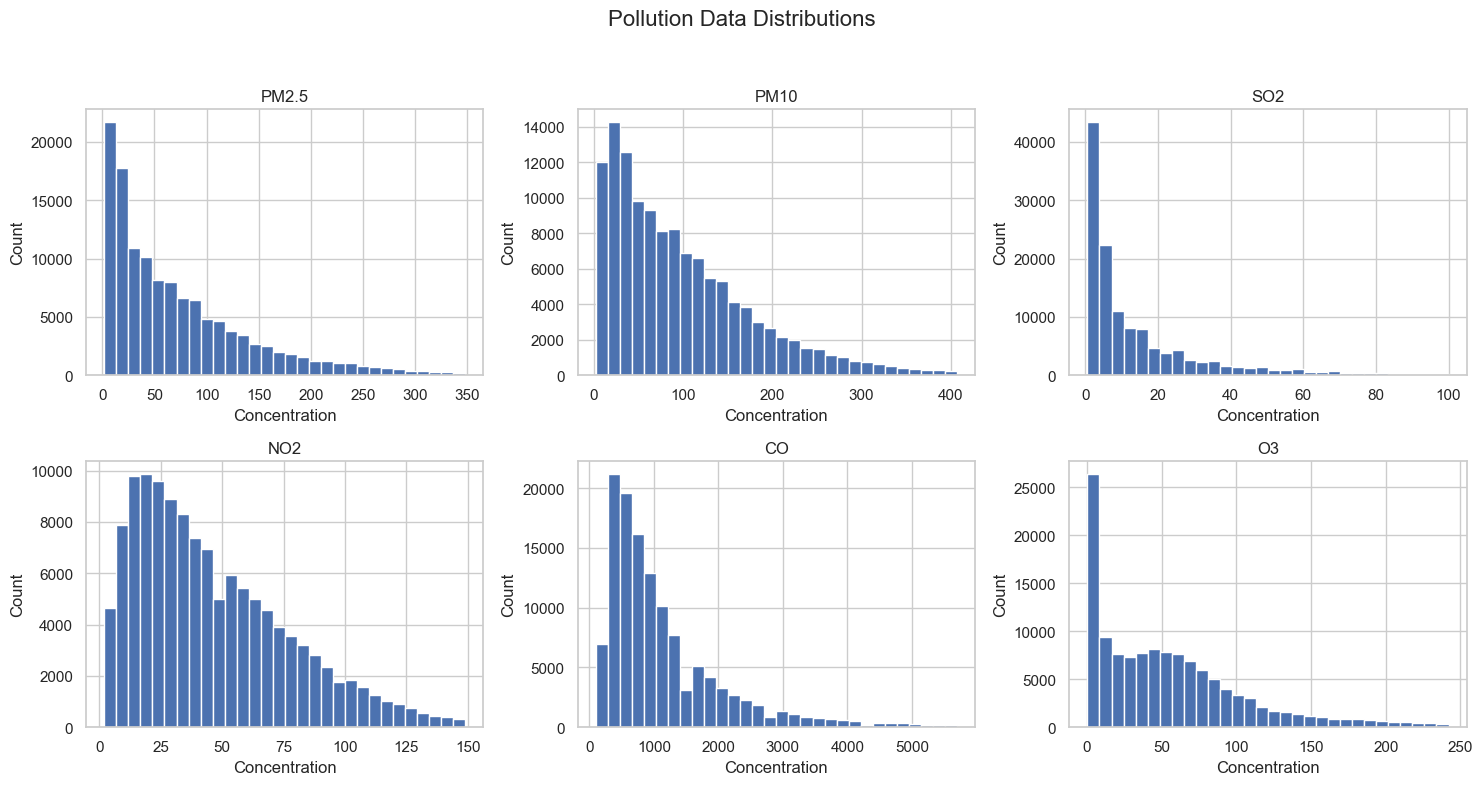

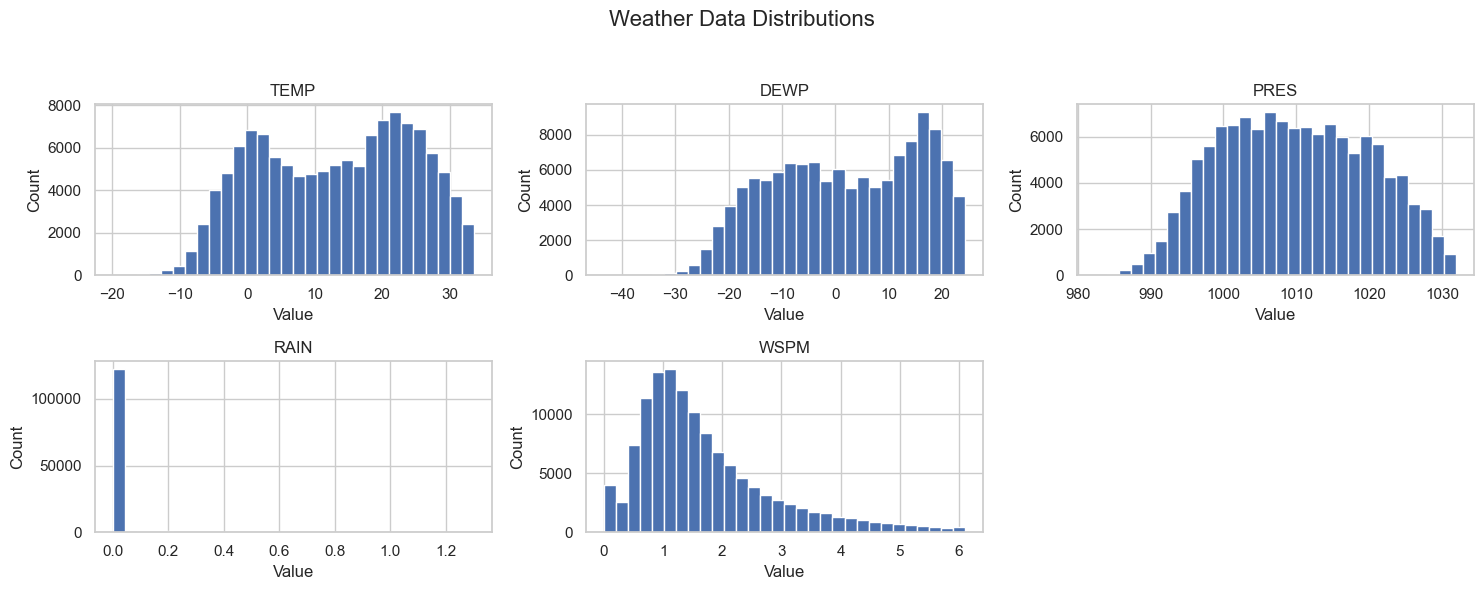

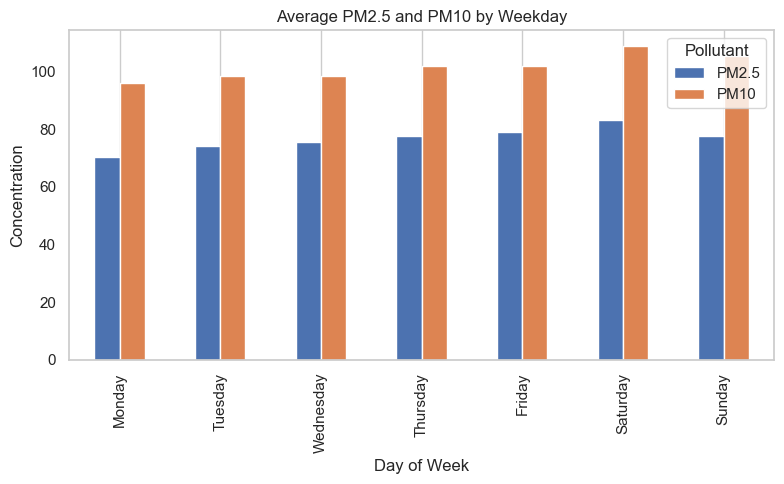

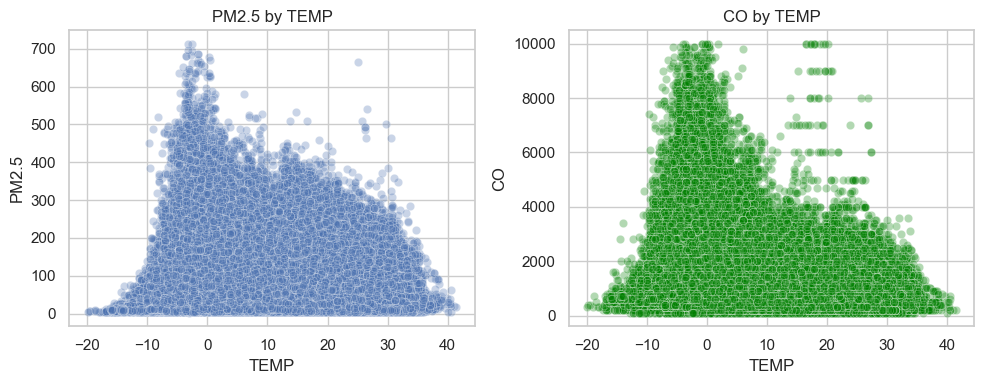

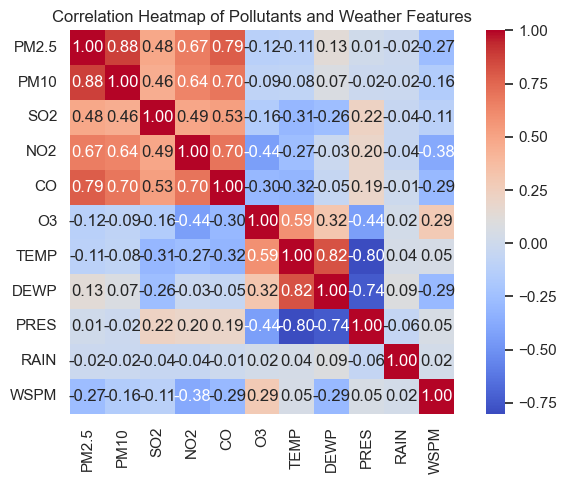

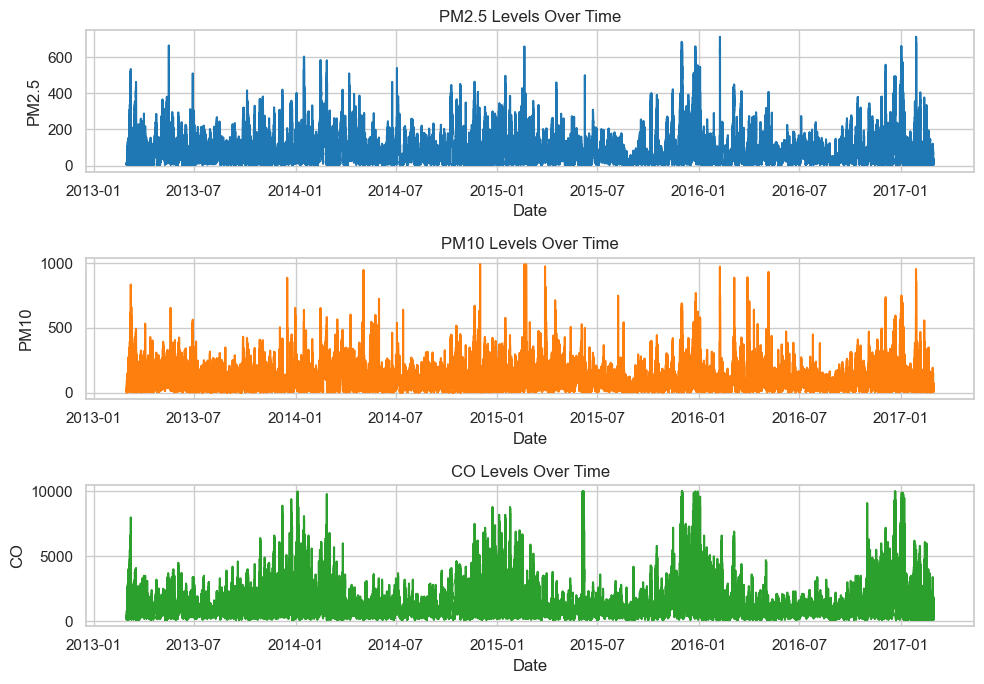

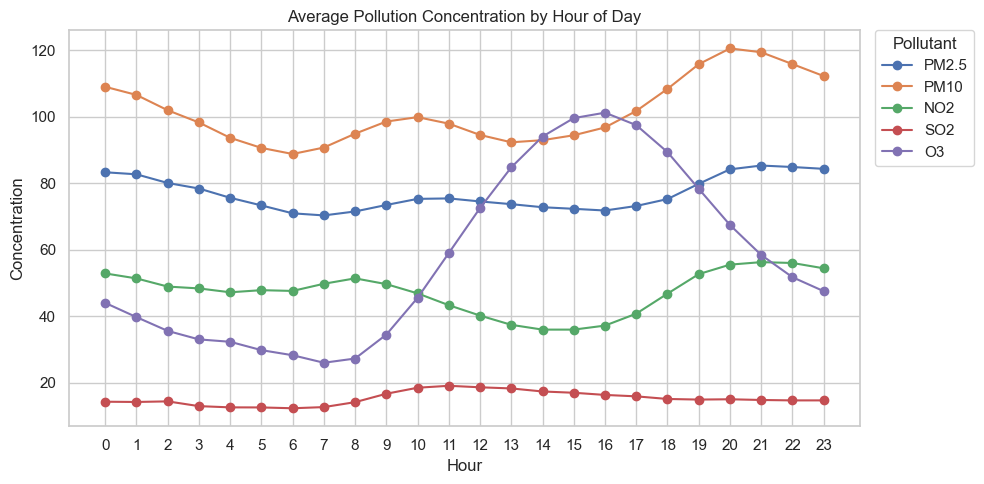

In [11]:
# Univariate Analysis
# Histograms for pollutant distribution, clipped to 99th percentile to reduce skew from extreme outliers
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
plt.figure(figsize=(15, 8))
for i, col in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    clipped = preprocessed_air_quality_data[col]
    clipped = clipped[clipped < clipped.quantile(0.99)]  # Clip to 99th percentile
    plt.hist(clipped.dropna(), bins=30)
    plt.title(col)
    plt.xlabel('Concentration')
    plt.ylabel('Count')
plt.suptitle('Pollution Data Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Histograms for weather distribution, clipped to 99th percentile to reduce skew from extreme outliers
weather = ['TEMP', 'DEWP', 'PRES', 'RAIN', 'WSPM']
plt.figure(figsize=(15, 6))
for i, col in enumerate(weather, 1):
    plt.subplot(2, 3, i)
    clipped = preprocessed_air_quality_data[col]
    clipped = clipped[clipped < clipped.quantile(0.99)]  # Clip to 99th percentile
    plt.hist(clipped.dropna(), bins=30)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Count')
plt.suptitle('Weather Data Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Bivariate Analysis
# Bar chart to show average weekday concentrations of PM2.5 and PM10
barchart_data = preprocessed_air_quality_data.groupby('day_name')[['PM2.5', 'PM10']].mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
barchart_data = barchart_data.loc[weekday_order]

barchart_data.plot(kind='bar', figsize=(8, 5))
plt.title('Average PM2.5 and PM10 by Weekday')
plt.ylabel('Concentration')
plt.xlabel('Day of Week')
plt.grid(axis='y')
plt.legend(title='Pollutant')
plt.tight_layout()
plt.show()

# Scatter plots showing pollutants by temperature
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x='TEMP', y='PM2.5', data=preprocessed_air_quality_data, alpha=0.3, ax=axes[0])
axes[0].set_title('PM2.5 by TEMP')
axes[0].grid(True)
sns.scatterplot(x='TEMP', y='CO', data=preprocessed_air_quality_data, alpha=0.3, color='green', ax=axes[1])
axes[1].set_title('CO by TEMP')
axes[1].grid(True)
plt.tight_layout()
plt.show()

# Multivariate Analysis
# Heatmap of all pollutant and weather data to identify relationships
plt.figure(figsize=(7, 5))
heatmap = preprocessed_air_quality_data[pollutants + weather].corr()
sns.heatmap(heatmap, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Pollutants and Weather Features')
plt.tight_layout()
plt.show()

#Line plots to visualise pollutant trends over time
line_plot = preprocessed_air_quality_data[['datetime', 'PM2.5', 'PM10', 'CO']].dropna().sort_values('datetime')
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# Set graph 
# PM2.5
axes[0].plot(line_plot['datetime'], line_plot['PM2.5'], color='tab:blue')
axes[0].set_title('PM2.5 Levels Over Time')
axes[0].set_ylabel('PM2.5')
axes[0].grid(True)

# PM10
axes[1].plot(line_plot['datetime'], line_plot['PM10'], color='tab:orange')
axes[1].set_title('PM10 Levels Over Time')
axes[1].set_ylabel('PM10')
axes[1].grid(True)

# CO
axes[2].plot(line_plot['datetime'], line_plot['CO'], color='tab:green')
axes[2].set_title('CO Levels Over Time')
axes[2].set_ylabel('CO')
axes[2].set_xlabel('Date')
axes[2].grid(True)

# Display date axis for all line plots
for ax in axes:
    ax.tick_params(labelbottom=True)
    ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

# Hourly trend analysis to compare how pollutants vary across the hours of the day
# Select pollutants excluding CO
hourly_pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3']

# Calculate hourly averages directly from datetime
hourly_avg_pollutants = preprocessed_air_quality_data.groupby(preprocessed_air_quality_data['datetime'].dt.hour)[hourly_pollutants].mean()

# Create visual
plt.figure(figsize=(10, 5))
for col in hourly_avg_pollutants.columns:
    plt.plot(hourly_avg_pollutants.index, hourly_avg_pollutants[col], label=col, marker='o')
plt.title('Average Pollution Concentration by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Concentration')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Pollutant', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

Exploratory Data Analysis was used to explore the preprocessed dataset for patterns and relationships across the data. A range of statistical and visualisation methods were used:

- Univariate histograms showed that most of the pollutants had a large number of lower concentration readings with few extreme values. The rain data had the majority of values at zero, as a result of no rain during most days. The other weather-based collected data such as temperature and pressure, showed a more balanced range with minimal outliers.
- A bar chart was used as a visualisation for comparing the average concentrations of 'PM2.5' and 'PM10' across each of the seven weekdays, this showed that there was slightly elevated pollution levels on weekends, potentially as a result of increased residential activity.
- Scatter plots were used to showcase the correlation of temperature and pollutants. The graphs showed a moderate negative correlation for 'PM2.5' and 'CO', which shows that pollution concentrations seem to decrease as the temperature increases.
- The correlation heatmap confirms a strong positive relationship between 'PM2.5' and 'PM10', whereas 'O3' was negatively correlated with many of the pollutants, this is likely due to its dependency on sunlight, which is contrary to what the other pollutants show in the scatter plots.
- Line plots of pollutant concentrations over time, showed several strong fluctuations, with visible seasonal variation, with 'CO' levels consistently higher during colder months, while the 'PM2.5' and 'PM10' showing slight consistencies but overall more broad fluctuations.
- An hourly trend analysis was also created, which showed 'PM2.5', 'PM10' and 'NO2' had morning and evening peaks, likely as a result of traffic increases during these times. whereas O3 heavily peaked in the afternoon, likely due to higher levels of sunlight.

These results showcase several meaningful patterns and relationships in air pollution over time, weather and day, providing valuable insight for developing an effective model.

# Task 3 Model Building

In [16]:
# Feature selection and prediction target
base_features = [
    'TEMP', 'DEWP', 'PRES', 'RAIN', 'WSPM',
    'day_name', 'month_name', 'wd', 'PM10', 'NO2', 'CO', 'hour'
]
target = 'PM2.5'

# Data preprocessing
# Extract hour from datetime
data = preprocessed_air_quality_data.copy()
data['hour'] = data['datetime'].dt.hour

# Categorise and encode data
data = data[base_features + [target]].dropna()
categorical = ['day_name', 'month_name', 'wd']
data_encoded = pd.get_dummies(data, columns=categorical, drop_first=True)

# Set features and target
X = data_encoded.drop(columns=[target])
y = data_encoded[target]

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random forest training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Linear regression training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

# Gradient boosting training
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

# Evaluation metrics function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R2  : {r2_score(y_true, y_pred):.3f}")

# calling evaluation function
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Gradient Boosting", y_test, gb_preds)

# Ensemble models
# Even split ensemble (RF + LR)
ensemble_even = (rf_preds + lr_preds) / 2
evaluate_model("Simple Ensemble (RF + LR)", y_test, ensemble_even)

# Weighted two model ensemble (70% RF + 30% LR)
ensemble_weighted_two = 0.7 * rf_preds + 0.3 * lr_preds
evaluate_model("Weighted Ensemble (70% RF + 30% LR)", y_test, ensemble_weighted_two)

# Weighted three model ensemble (60% RF + 30% GB + 10% LR)
ensemble_weighted_three = 0.6 * rf_preds + 0.3 * gb_preds + 0.1 * lr_preds
evaluate_model("Weighted Ensemble (60% RF + 30% GB + 10% LR)", y_test, ensemble_weighted_three)

# Random Forest data importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
important_features = importances.sort_values(ascending=False).head(10)
print("\nMost important features (Random Forest):")
display(important_features.to_frame("Importance"))

# Linear Regression coefficients
lr_coefficients = pd.Series(lr_model.coef_, index=X.columns)
important_lr = lr_coefficients.abs().sort_values(ascending=False).head(10)
print("\nMost important coefficients (Linear Regression):")
display(important_lr.to_frame("Coefficient"))



Random Forest Performance:
MAE : 11.47
RMSE: 18.80
R2  : 0.941

Linear Regression Performance:
MAE : 19.26
RMSE: 29.40
R2  : 0.856

Gradient Boosting Performance:
MAE : 14.62
RMSE: 22.91
R2  : 0.912

Simple Ensemble (RF + LR) Performance:
MAE : 14.48
RMSE: 22.15
R2  : 0.918

Weighted Ensemble (70% RF + 30% LR) Performance:
MAE : 12.93
RMSE: 20.19
R2  : 0.932

Weighted Ensemble (60% RF + 30% GB + 10% LR) Performance:
MAE : 12.55
RMSE: 19.86
R2  : 0.934

Most important features (Random Forest):


,Importance
PM10,0.804766
CO,0.102136
DEWP,0.020402
NO2,0.011981
TEMP,0.011828
PRES,0.010445
WSPM,0.007098
hour,0.006956
month_name_May,0.001721
month_name_November,0.001333



Most important coefficients (Linear Regression):


,Coefficient
PM10,46.392480
CO,23.689092
DEWP,23.420705
month_name_February,7.596190
month_name_August,7.322356
month_name_January,6.888387
month_name_September,5.226280
month_name_June,4.750900
month_name_July,4.406219
month_name_December,4.199753


A machine learning pipeline was created to predict 'PM2.5' concentrations using a range of features such as weather-based data, time-based data and some other pollutants, PM10, NO2 and CO. Variables such as wind direction, week day and month name were categorised and time of day was extracted from the datetime column.

Three base models were trained and evaluated:
- Random forest
- Linear regression with StandardScaler
- Gradient boosting

Three ensemble models were also tested containing combinations of the base models:
- Even split of random forest and linear regression
- Weighted two model ensemble of 70% random forest and 30% linear regression
- Weighted three model ensemble of 60% random forest, 30% gradient boosting and 10% linear regression

Their performances were measured using mean absolute error, mean squared error and R2 score, the random forest model performed best in all 3 of the evaluation metrics.

Feature importance and coefficient analysis showed:
- PM10 was the most influential feature by far across both random forest and linear regression
- CO, DEWP, TEMP and NO2 were also prominent indicators
- Time-related features such as month, were less important for random forest but quite a strong influence in linear regression

These results showcase the strong predictive performance and supports the effectiveness of the selected features.

In [33]:
# Cross-Validation testing
# Define models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Run 5-fold cross-validation for each of the models
print("Cross-Validation Scores (5-fold):")

# Random Forest
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Random Forest     : R2 Score: {rf_scores.mean():.3f}, SD: {rf_scores.std():.3f}")

# Linear Regression
lr_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
print(f"Linear Regression : R2 Score: {lr_scores.mean():.3f}, SD: {lr_scores.std():.3f}")

# Gradient Boosting
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='r2')
print(f"Gradient Boosting : R2 Score: {gb_scores.mean():.3f}, SD: {gb_scores.std():.3f}")

Cross-Validation Scores (5-fold):
Random Forest     : R2 Score: 0.922, SD: 0.010
Linear Regression : R2 Score: 0.855, SD: 0.008
Gradient Boosting : R2 Score: 0.908, SD: 0.010


5-fold cross-validation was applied, evaluating the robustness of each trained model across the different data splits. This process ensures the models performance is not dependent on a specific partition of the dataset.

The R2 scores show the average performance of the model, while the standard deviation displays consistency. The random forest model remained the strongest with an R2 score of 0.922 and remained comparable to the other two models in terms of consistency.

In [31]:
# Grid Search
# Define parameter grid balancing performance and speed
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the GridSearchCV to find best combination
rf_base_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_base_model,
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Run grid search
rf_grid_search.fit(X, y)

# Display best configuration and score
print("\nBest Parameters (Random Forest):")
print(rf_grid_search.best_params_)
print("\nBest Cross-Validated R2 Score:")
print(f"{rf_grid_search.best_score_:.3f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters (Random Forest):
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Cross-Validated R2 Score:
0.925


To optimise the performance of the random forest model on the dataset, a grid search was performed using a parameter grid. The search used various tree depth, estimators, feature selection strategies, leaf constraints and split constraints, while keeping runtime reasonable.

The grid search evaluated 108 combinations using 5-fold cross-validation for a total of 540 runs, from these the best configuration found was:

- Number of estimators = 200
- Maximum tree depth = None
- Minimum samples to split node = 2
- Minimum samples at leaf node = 1
- Number of features = 'sqrt'

This configuration achieved a cross-validated R2 score of 0.925 proving the models use as the final model.

In [31]:
# Train final model with tuned hyperparameters chosen from grid search
final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
# fit model on dataset
final_model.fit(X, y)

# Evaluate final model on test set
final_preds = final_model.predict(X_test)

print("Final Tuned Model Performance:")
print(f"MAE : {mean_absolute_error(y_test, final_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, final_preds)):.2f}")
print(f"R2  : {r2_score(y_test, final_preds):.3f}")

# Cross-validation to verify robustness
final_cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='r2')
print("\nCross-Validation R2:")
print(f"Mean R2 : {final_cv_scores.mean():.3f}")
print(f"Std Dev : {final_cv_scores.std():.3f}")

# Save trained model and feature set as pkl for use in GUI
joblib.dump(final_model, 'air_pollution_model.pkl')
print("\nModel saved as 'air_pollution_model.pkl'")
joblib.dump(X.columns.tolist(), 'model_features.pkl')
print("model features saved as 'model_features.pkl'")


Final Tuned Model Performance:
MAE : 4.09
RMSE: 6.57
R2  : 0.993

Cross-Validation R2:
Mean R2 : 0.925
Std Dev : 0.009

Model saved as 'air_pollution_model.pkl'
model features saved as 'model_features.pkl'


The final predictive model was built using the random forest regressor, trained on the prepared dataset using the best hyperparameters identified during the grid search.
The model was able to achieve a strong performance on the test set with metrics of:
- Mean absolute error: 4.09
- Root mean squared error: 6.57
- R2 score: 0.993

The low MAE and RMSE showcase the models consistency at making accurate predictions and the strong R2 score of 0.993 proves that the model is able to explain almost all variation in PM2.5 concentrations.

To ensure the final model was robust, a 5-fold cross-validation was performed across the full dataset:
- R2 score: 0.925
- Standard deviation: 0.009

These results display a highly accurate predictive model for both performance and consistency, making the model suitable for deployment for predicting air pollution. The model was exported as a .pkl file for use in the GUI development.

In [32]:
# Train lightweight version of the final model with smaller file size for GUI use Based on tuned hyperparameters from grid search but with reduced n_estimators to meet submission and github limits
# Train lightweight model with tuned hyperparameters chosen from grid search
lightweight_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
# fit model on dataset
lightweight_model.fit(X, y)

# Evaluate lightweight model on test set
lightweight_preds = lightweight_model.predict(X_test)

print("Final Tuned Model Performance:")
print(f"MAE : {mean_absolute_error(y_test, lightweight_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lightweight_preds)):.2f}")
print(f"R2  : {r2_score(y_test, lightweight_preds):.3f}")

# Cross-validation to verify robustness
lightweight_cv_scores = cross_val_score(lightweight_model, X, y, cv=5, scoring='r2')
print("\nCross-Validation R2:")
print(f"Mean R2 : {lightweight_cv_scores.mean():.3f}")
print(f"Std Dev : {lightweight_cv_scores.std():.3f}")

# Save lightweight model as a smaller .pkl file for GUI deployment
joblib.dump(lightweight_model, 'lightweight_air_pollution_model.pkl')
print("\nModel saved as 'lightweight_air_pollution_model.pkl'")

Final Tuned Model Performance:
MAE : 4.27
RMSE: 6.89
R2  : 0.992

Cross-Validation R2:
Mean R2 : 0.924
Std Dev : 0.009

Model saved as 'lightweight_air_pollution_model.pkl'


To meet the 100MB upload size restriction for the assignment submission link and github repository, a second lightweight version of the final Random Forest model was trained using the best hyperparameters from the grid search, but with a reduced number of estimators with 50 instead of 200.

The lightweight model is functionally suitable for use within the Streamlit GUI and retains strong predictive accuracy:

- MAE: 4.27  
- RMSE: 6.89  
- R2: 0.992  
- Mean R2: 0.924
- Standard Deviation: 0.009

The full model trained with the complete grid search parameters achieved an R2 score of 0.993, but exceeded the submission size limits. The lighter model was saved as `'GUI_air_pollution_model.pkl'` for app integration with a similar R2 score of 0.992.

# Task 4 Application Development

In [ ]:
# Code to open GUI
!streamlit run GUI.py